## Plot DETR log

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from notebook_utils import *

In [2]:
log_directory = [Path('output/')] # change path

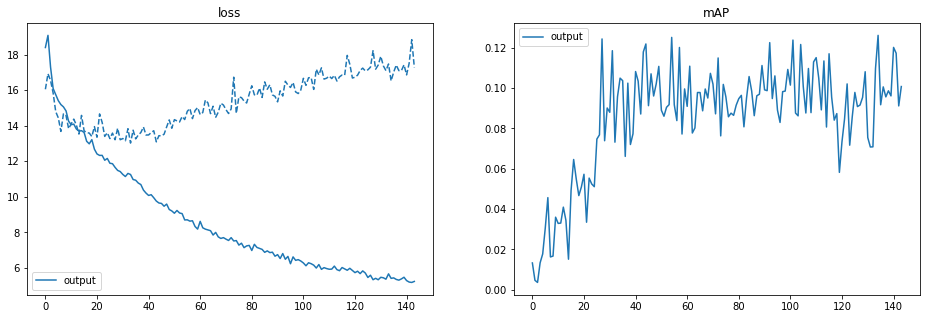

In [3]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

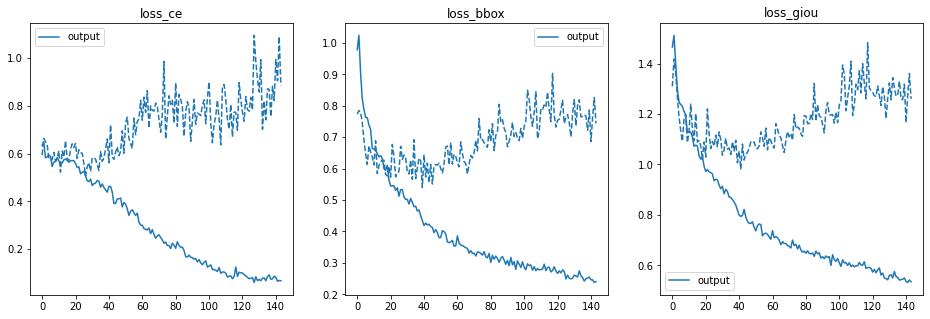

In [4]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

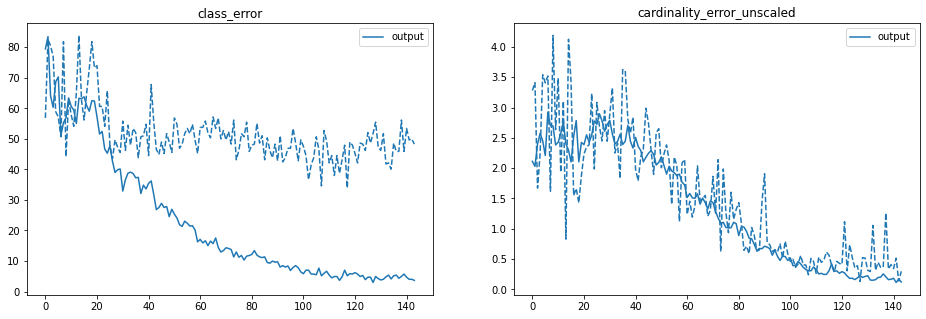

In [5]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the trained model

In [6]:
num_classes=2

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('best.pth',
                        map_location='cuda')

model.query_embed = torch.nn.Embedding(20, 256)

model.load_state_dict(checkpoint['model'],
                      strict=False)

model = model.cuda()
model.eval()

Using cache found in /home/rensortino/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [7]:
# CLASSES = ['No-Object', 'Stenosis']
CLASSES = ['No-Object', 'galaxy', 'source', 'sidelobe']
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098]]

In [8]:
out_box_file = Path('rg-boxes.json')
if out_box_file.exists():
    out_box_file.unlink()

## Visualization functions

In [9]:
from PIL import Image
test_dir = Path('data/radio-galaxy/test')
import json

### Run inference on dataset

In [12]:
plt.ioff()
pred_folder_path = Path('predictions')
pred_folder_path.mkdir(exist_ok=True)
out_boxes = {}
batch_idx = 0
confidence_threshold = 0.0
for img_path in test_dir.glob('*[.jpeg .png]'):

    img = Image.open(img_path)
    img = apply_transforms(img)

    if img is None:
        continue
    img = img.unsqueeze(0)
    img = img.cuda()

    outputs = model(img)

    img_name = img_path.stem

    out_boxes[img_name] = {}
    img = img[batch_idx]

    labels, pred_boxes, confidence = format_output(outputs, confidence_threshold, batch_idx)
    if labels is None or pred_boxes is None or confidence is None:
        out_boxes[img_name]['labels'] = 'None'
        out_boxes[img_name]['boxes'] = 'None'
        out_boxes[img_name]['scores'] = 'None'
        continue
    else:
        bboxes_scaled = rescale_bboxes(pred_boxes, img.shape[1:])
        out_boxes[img_name]['labels'] = [CLASSES[cl_idx] for cl_idx in labels.tolist()]
        # out_boxes[img_name]['rel_boxes'] = pred_boxes.tolist()
        out_boxes[img_name]['boxes'] = bboxes_scaled.tolist()
        out_boxes[img_name]['scores'] = confidence.tolist()

with open(out_box_file, 'w') as out_json:
    json.dump(out_boxes, out_json)

In [ ]:
import gc
gc.collect()

In [ ]:
torch.cuda.empty_cache() 

## Log single images

In [ ]:
def log_image(pil_img, labels, boxes, confidence, title):
    '''
    labels, boxes and confidence are lists
    '''
    fig = plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for cl, (xmin, ymin, xmax, ymax), cs, in zip(labels, boxes, confidence):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=COLORS[cl], linewidth=3))
        text = f'{CLASSES[cl]}: {cs:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    return fig

In [ ]:
img_path = Path('data/fMRI/test/IMG00001.jpeg')

img = Image.open(img_path)
img = apply_transforms(img)

img = img.unsqueeze(0)
img = img.cuda()

outputs = model(img)

labels, pred_boxes, confidence = format_output(outputs, confidence_threshold, batch_idx)
img = img[batch_idx]

denorm_img = inv_normalize()(img)
orig_image = torchvision.transforms.functional.topilimage(denorm_img)

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(pred_boxes, img.shape[1:])

fig = log_image(orig_image, labels.tolist(), bboxes_scaled.tolist(), confidence.tolist(), 'Prediction')

In [ ]:
with open('data/fMRI/annotations/test.json') as ann:
    print(len(json.load(ann)['annotations']))


# target = targets[idx]

# # convert boxes from [0; 1] to image scales
# bboxes_scaled = rescale_bboxes(target['boxes'], target['size'])

# confidence = [1.0] * target['boxes'].shape[0]
# log_image(orig_image, target['labels'], bboxes_scaled, confidence, 'Ground Truth')